# TSSL Exam - 2020-12-04
This notebook contains the four exam problems.

* Please write your solutions directly in the notebook.

* Your submission should consist of: (i) an executable notebook (.ipynb file), **and** a pdf printout of the same notebook. Please make sure that all your answers are visible in the pdf file. To generate the pdf file from the notebook, you can either go to _File->Download as->PDF via LaTeX (.pdf)_, or go to _File->Print preview_ and "print" the web page as a pdf file.

* If relevant, hand-written calculations and drawings can be submitted alongside the notebook/pdf printout. Please scan/take a picture of your hand-written solutions and upload them in pdf, jpg or png format alongside the notebook. If you use this option, you need to **clearly mark in the notebook** that part of the solution is attached as a separate file and provide a reference to that file.  

* Apart from the exception mentioned above, the notebook should be self-contained and executable. Standard packages and the `tssltools` module that is **distributed along with the exam** may be imported. This module contains **all the auxiliary code that you have used in the labs**, i.e. from the `tssltools_lab#` files, regardless of whether or not these functions/classes are relevant for solving the exam. The `tssltools` module also contains some additional code that can come in handy (in that case, the relevant code is referred to in the problem formulation).
If you rely on external code that you have written (e.g. when solving the lab assignments in the course) it should be copied in to the notebook.

* **Responsible teacher:** Fredrik Lindsten, available over email (fredrik.lindsten@liu.se) or phone (070 085 07 90) during the exam.  


### Grades
The maximum number of points is 40 (8+13+12+7 for the four problems, respectively). The _tentative_ levels for the grades (A-F) are:
- A=37-40 points
- B=33-36 points
- C=23-32 points
- D=19-22 points
- E=15-18 points
- F=0-14 points (fail)

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Default figure size for plots.
# Feel free to change this if the suggested setting results in too small/large plots on your machine!
plt.rcParams["figure.figsize"] = (10,6)

## Problem 1:
(9 points)

**a)** The file `data_problem1.csv` contains a sequence of 1000 observations. In this problem you should do the following:

1. Load the data. Split it into training data (the first $n=800$ data points) and validation data (the remaining $m=200$ data points).
2. Fit an AR$(3)$ model to the training data. _No data preprocessing is necessary!_
3. Compute the one-step-ahead predictions $\hat y_{t|t-1}$ for _ALL_ validation data points. That is, you should have a sequence of $m=200$ predictions. Plot $y_{t}$ and $\hat y_{t|t-1}$ for $t = n+1, \dots, n+m$ in the same figure and compute the prediction root-mean-squared error.

_Hint:_ You can use the functions `fit_ar`, `predict_ar_1step` and `acfplot` from lab 1 (also available in `tssltools`).  

<div style="text-align: right"> (4p) </div>


In [7]:
data=pandas.read_csv('data_problem1.csv',header=0)
y = data['Data'].values

**Solution:**

In [8]:
from tssltools import fit_ar, predict_ar_1step, acfplot

1. First we split into train/test

In [9]:
ndata = len(y)
n = 800
m = ndata-n

ytrain = y[:n]
yval = y[n:]

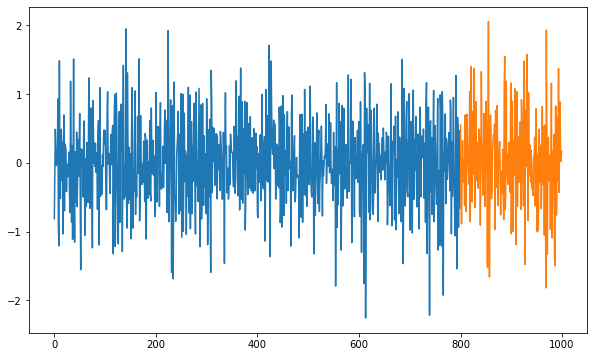

In [10]:
plt.plot(range(n),ytrain)
plt.plot(range(n,ndata),yval)

2. Fit an AR(3) model

In [11]:
p = 3
th = fit_ar(ytrain, p)

3. Compute one-step predictions

In [12]:
help(predict_ar_1step)

Help on function predict_ar_1step in module tssltools:

predict_ar_1step(theta, y_target)
    Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.
    
    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n)



0.5771969838395323

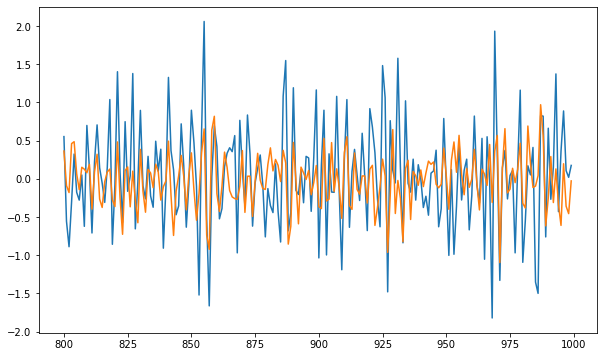

In [17]:
yhat = predict_ar_1step(th, y)
plt.plot(range(n,ndata), y[n:])
plt.plot(range(n,ndata), yhat[n-p:])

## RMSE
np.sqrt(np.mean( (y[n:] - yhat[n-p:])**2 ))

___

**b)** Plot the autocorrelation function of the _residuals_ on the validation data. Explain if and how the ACF plot differs from the ideal case. 

<div style="text-align: right"> (2p) </div>

**Solution:**

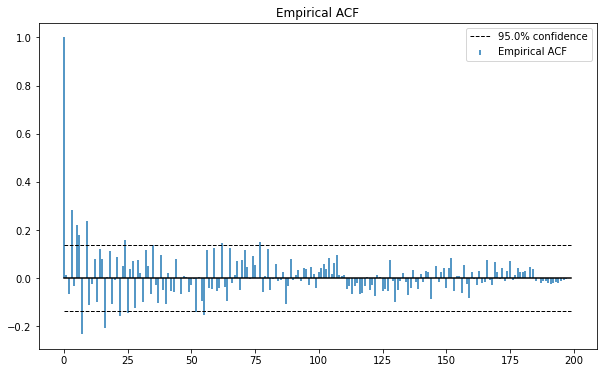

In [18]:
acfplot(y[n:]-yhat[n-p:])

The ideal case would correspond to an ACF which is constantly zero for all positive lags. Here we have remaining autocorrelation among the residuals, suggesting the the model does not capture all the temporal dependencies in the data.

___

**c)** Compute the model simulation (long-range prediction) on the validation data, $\hat y_{t|n}$ for $t = n+1,\dots, n+m$. Explain why the simulation _converges to a constant value_.

_Hint:_ If you were not able to solve part a), you can still solve this part of the problem. In that case, do the simulation using an AR($p=3$) model with a randomly chosen parameter vector.

<div style="text-align: right"> (3p) </div>

**Solution**

In [19]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point

    for i in range(m):
        y_sim[i] = np.sum( phi * theta )
        phi[1:] = phi[:-1]  # Drop the last entry
        phi[0] = y_sim[i]   # Add the predicted value to the regression vector
        
    return y_sim

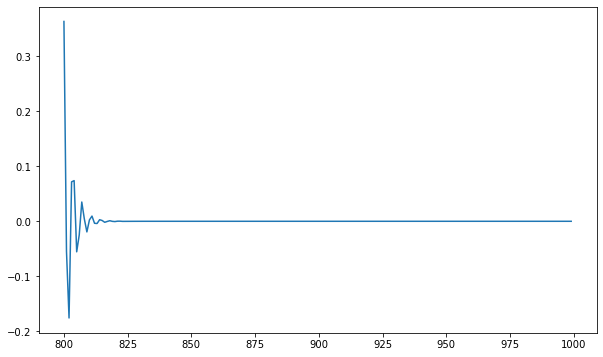

In [20]:
y_sim = simulate_ar(y[:n], th, m)
plt.plot(np.arange(n,n+m), y_sim)


The AR model is stable, meaning that the long-range prediction converges to the mean prediction, which is zero.

## Problem 2:
(11 points)

**a)** In this problem we will study an AR(3) model observed in noise, that is a model as follows,

$$
    \begin{cases} \tilde{\alpha}_t = a_1 \cdot \tilde{\alpha}_{t-1} + a_2 \cdot \tilde{\alpha}_{t-2} + a_3 \cdot \tilde{\alpha}_{t-3} + \eta_t, & \eta_t \sim \mathcal{N}(0,\sigma_{\eta}^{2}), \\
    y_t = c \cdot \tilde{\alpha}_t + \varepsilon_t, & \varepsilon_t \sim \mathcal{N}(0,\sigma_{\varepsilon}^{2}). \end{cases}
$$

Here $\tilde{\alpha}_t$ is a univariate signal. These types of models can arise in many scenarios. To work with them it is often easier to work with a state-space model version. That is to work with a model of the following form

$$
    \begin{cases}
        \alpha_t = T \alpha_{t-1} + R \eta_t \\
        y_t = Z \alpha_{t} + \varepsilon_t.
    \end{cases}
$$

In this problem you should do the following:
1. Write the model as a state-space model. Remember to specify the matrices $T$, $R$, and $Z$. Also specify your hidden state $\alpha_t$ and the noise variables.
2. Model stability is often something that is important. Let $(a_1, a_2, a_3) = (1,\, 0.7,\, -0.8), c = 2, \, \sigma_{\eta}^{2} = 0.5$, and $\sigma_{\varepsilon}^{2} = 2$. Is the model stable?

<div style="text-align: right"> (5p) </div>

**Solution**

1. 

We need 3 states to calculate the new value so we set $\alpha_t = (\tilde{\alpha}_t, \tilde{\alpha}_{t-1}, \tilde{\alpha}_{t-2})^{T}$. By following the equations and using that $\tilde{\alpha}_{t-1}$, and $\tilde{\alpha}_{t-2}$ appears in both $\alpha_t$ and $\alpha_{t-1}$. We then get that
$$
    T = \begin{pmatrix} a_1 & a_2 & a_3 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{pmatrix} \quad R = \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix} \quad Z = \begin{pmatrix} c & 0 & 0 \end{pmatrix}.
$$
Finally the noise variables are the same in both models.

2. 

For the stability we need to calculate the eigenvalues of the matrix $T$. We then look at where they are placed on the complex plane. If all of them are within the unit circle then the system is stable, if some are on the circle boarder with the rest inside the system is marginally stable and if any of them are outside the unit circle the system is unstable.

In [21]:
a1 = 1
a2 = .7
a3 = -.8

T = np.zeros((3,3))
T[0,0] = a1
T[0,1] = a2
T[0,2] = a3
T[1,0] = 1
T[2,1] = 1

R = np.zeros((3,1))
R[0,0] = 1

c = 2
Z = np.zeros((1,3))
Z[0,0] = c

w, _ = np.linalg.eig(T)
print(np.abs(w))

[0.86806187 0.95999651 0.95999651]


The system is stable.

___

**b)** In the file `data_problem2.csv` a sequence of 500 observations from this model is given. We are now interested in estimating the filtered mean of the hidden signal.

1. Set the mean values of the initial states to the same value (that is, the mean is a vector with all entries being equal), such that $\hat{y}_{1 \mid 0} = y_1$. Set the covariance matrix of the initial state to $10 I$.
2. Implement and run the Kalman filter on the provided data using the parameter values in **a)**
3. Plot the observations and the filtered mean of the hidden signal $\tilde{\alpha}_t$.

<div style="text-align: right"> (3p) </div>

**Solution**

In [22]:
from tssltools import LGSS, kfs_res

data2 = pandas.read_csv('data_problem2.csv', header=None).values.flatten()

sigma2_eta = .5
sigma2_eps = 2.

a1 = np.zeros(3)
a1[:] = data2[0]/c

P1 = 10*np.eye(3)
model = LGSS(T, R, np.array([[sigma2_eta]]), Z, sigma2_eps, a1, P1)

help(model.get_params)

# 3. Kalman filter implementation
def kalman_filter(y, model: LGSS):
    """Kalman filter for LGSS model with one-dimensional observation.

    :param y: (n,) array of observations. May contain nan, which encodes missing observations.
    :param model: LGSS object with the model specification.
    
    :return kfs_res: Container class with member variables,
        alpha_pred: (d,1,n) array of predicted state means.
        P_pred: (d,d,n) array of predicted state covariances.
        alpha_filt: (d,1,n) array of filtered state means.
        P_filt: (d,d,n) array of filtered state covariances.
        y_pred: (n,) array of means of p(y_t | y_{1:t-1})
        F_pred: (n,) array of variances of p(y_t | y_{1:t-1})
    """

    n = len(y)
    d = model.d  # State dimension
    alpha_pred = np.zeros((d, 1, n))
    P_pred = np.zeros((d, d, n))
    alpha_filt = np.zeros((d, 1, n))
    P_filt = np.zeros((d, d, n))
    y_pred = np.zeros(n)
    F_pred = np.zeros(n)

    T, R, Q, Z, H, a1, P1 = model.get_params()  # Get all model parameters (for brevity)

    for t in range(n):
        # Time update (predict)
        if t == 0:  # Initialize predictions
            alpha_pred[:, 0, 0] = a1  # a1 is a (d,) array
            P_pred[:, :, 0] = P1
        else:
            alpha_pred[:, :, t] = T @ alpha_filt[:, :, t - 1]
            P_pred[:, :, t] = T @ P_filt[:, :, t - 1] @ T.T + R @ Q @ R.T

        # Compute prediction of current output
        y_pred[t] = Z @ alpha_pred[:, :, t]
        F_pred[t] = Z @ P_pred[:, :, t] @ Z.T + H

        # Measurement update (correct)
        if np.isnan(y[t]):  # Handle missing data
            alpha_filt[:, :, t] = alpha_pred[:, :, t].copy()
            P_filt[:, :, t] = P_pred[:, :, t].copy()
        else:
            K = P_pred[:, :, t] @ Z.T / F_pred[t]
            alpha_filt[:, :, t] = alpha_pred[:, :, t] + K * (y[t] - y_pred[t])
            """Here there is a notational benefit from working with (d,1,n) arrays instead of (d,n) arrays. K is (d,1)
            and so is alpha_pred[:,:,t]. If we would instead have alpha_pred[:,t] with alpha_pred being (d,n) we would
            get (d,) + (d,1) which is (insanely!) broadcasted to (d,d)."""
            P_filt[:, :, t] = (np.identity(d) - K @ Z) @ P_pred[:, :, t]

    kf = kfs_res(alpha_pred, P_pred, alpha_filt, P_filt, y_pred, F_pred)
    return kf



Help on method get_params in module tssltools:

get_params() method of tssltools.LGSS instance
    Return all model parameters.
    
    T, R, Q, Z, H, a1, P1 = model.get_params()



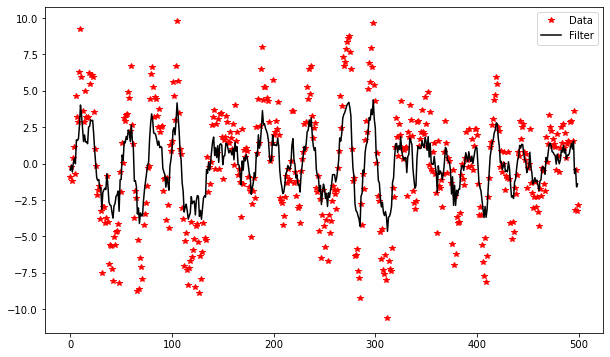

In [23]:
kf = kalman_filter(data2, model)
plt.figure()
plt.plot(data2,'r*')
plt.plot(kf.alpha_filt[0,0,:],'k')
plt.legend(['Data','Filter'])

___

**c)** Finally, as is often the case, we assume that there are unknown model parameters that need to be estimated. In our case we assume that $c$ is an unknown constant, the only knowledge that we have about it is that it is a value between .1 and 3. We use the same data as before and all other parameters are set to the same values.

1. Plot the log-likelihood function over this interval.
2. Find the value $c^*$ that maximizes the likelihood. The maximum error in your estimate should be at most 0.05.

<div style="text-align: right"> (3p) </div>

**Solution**

In [24]:
c_vals = np.linspace(.1,3,60)
llh_vals = np.zeros_like(c_vals)
for i in range(len(c_vals)):
    Z = np.zeros((1,3))
    Z[0,0] = c_vals[i]    
    model.Z = Z
    model.a1[:] = data2[0]/c_vals[i]
    kf = kalman_filter(data2, model)
    llh_vals[i] = -0.5 * np.sum( np.log(2*np.pi*kf.F_pred) + (data2 - kf.y_pred)**2/kf.F_pred)

Max value is c = 0.9847457627118643


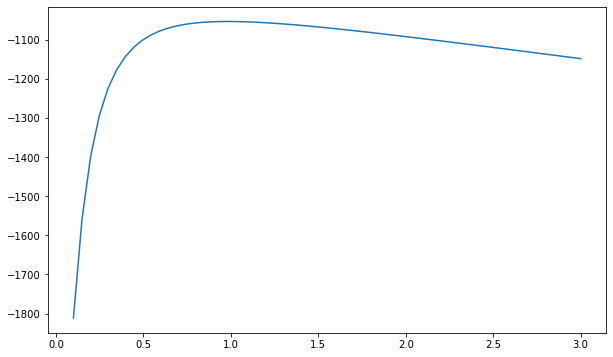

In [25]:
plt.figure()
plt.plot(c_vals,llh_vals)
print("Max value is c = {}".format(c_vals[np.argmax(llh_vals)]))

## Problem 3:
(12 points)

The file `data_problem3.csv` contains a sequence of observations. We will model this sequence using the following non-linear state space model,

$$
    \begin{cases} \alpha_{t+1} = 0.9 \alpha_t + 0.1 + \sigma_{\eta} \eta_t, & \eta_t \sim \mathcal{N}(0,1) \\
    y_t \sim \mathrm{Po}( \exp(\alpha_t)).
    \end{cases}
$$

with initial distribution $\alpha_1 \sim \mathcal{N}(1,\sigma_{\eta}^{2})$. Here, $\mathrm{Po}(\lambda)$ denotes the Poisson distribution with parameter $\lambda$.

**a)** To implement a bootstrap particle filter we need to perform three operations, propagation, weighting, and resampling. In this problem you should do the following:

1. Implement a function that takes $N$ particles $\alpha_t^i$ and propagates them to $\alpha_{t+1}^i$, by sampling from the state dynamics.
2. Implement a function that takes $N$ particles $\alpha_t^i$ and an observation $y_t$ and calculates the log-weights $\log \omega_t^i$.

<div style="text-align: right"> (5p) </div>

**Solution:**

In [27]:
# 1. Propagation function
# We sample new particles from the transition/state update equation conditionally on the current particles
def propagate(particles, sigma_eta):
    N = len(particles)
    new_particles = .9 * particles + 0.1  + sigma_eta*np.random.randn(N)
    return new_particles

# 2. Log-weight computation
# The log-weights are given by the log-pdf from part 1, evaluated at all particles
def logweight_fun(particles, y):
    logweights = y * particles - np.exp(particles) - np.log(np.math.factorial(y))
    return logweights

----

**b)** using the functions from the previous part implement a **Bootstrap Particle Filter** that runs on the data. You should solve the following parts:

1. Set the parameter $\sigma_{\eta} = 0.1$
2. Use the bootstrap particle filter to calculate the filtered intensity of the observations.

$$
    \mathbb{E}[\exp(\alpha_t) \mid y_{1:t}]
$$

3. Provide a plot of your intensity estimate and the observations.

Use $N = 200$ particles when performing your estimates.

If you failed to do the first part you can use the functions `propagate_wrong` and `logweight_fun_wrong` from the `tssltools` module to implement and run your bootstrap particle filter.

<div style="text-align: right"> (7p) </div>

**Solution:**

In [28]:
# Helper function

def exp_norm(logW):
    const = np.max(logW)
    W = np.exp(logW - const)
    sumofweights = np.sum(W)
    logZ = np.log(sumofweights) + const
    W = W / sumofweights
    return W, logZ

In [43]:
#from tssltools import propagate_wrong, logweight_fun_wrong

par = np.array([.1]) # 1. State noise
N = 200

# 2. Particle filter implementation
def bpf(y, N, par):
    n = len(y)
    particles = np.zeros((n,N))
    logWeights = np.zeros((n,N))
    weights = np.zeros((n,N))
    
    estInt = np.zeros(n)
    
    particles[0,:] = 1 + par[0]*np.random.randn(N)
    logWeights[0,:] = logweight_fun(particles[0,:], y[0])
    weights[0,:],_ = exp_norm(logWeights[0,:])
    
    estInt[0] = np.sum(weights[0,:] * np.exp(particles[0,:]))
    
    for t in range(1,n):
        # RESAMPLE
        ind = np.random.choice(N,N,True,p=weights[t-1,:])
        
        # PROPAGATE
        particles[t,:] = propagate(particles[t-1,ind], par[0])
        
        # WEIGHTING
        logWeights[t,:] = logweight_fun(particles[t,:], y[t])
        weights[t,:], _ = exp_norm(logWeights[t,:])
        
        # ESTIMATES
        estInt[t] = np.sum(weights[t,:] * np.exp(particles[t,:]))
    
    return estInt
    
    

In [44]:
# ...load the data
data3=pandas.read_csv('data_problem3.csv', header=None).values.flatten()

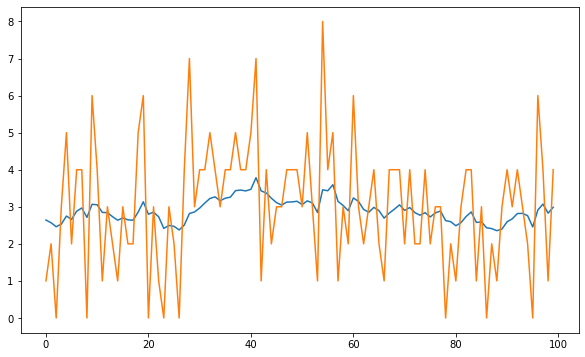

In [45]:
# ... Run the PF
estI = bpf(data3,N,par)

# 3. We compute the variance estimate and plot the result

plt.figure()
plt.plot(estI)
plt.plot(data3)

## Problem 4:
(8 points)

**a)** Is a simple one-layer Jordan-Elman RNN (`SimpleRNN` in Keras) with $p$ hidden units a equivalent to a NAR($p$) model with an MLP nonlinearity? If yes, explain why. If no, explain why not (e.g. by providing a counterexample).

<div style="text-align: right"> (3p) </div>

**Solution:**

No, the RNN has a hidden state vector. The state has the capacity to aggregate information from the entire past observation sequence in a way which is not possible using a NAR($p$) model, which only considers the past $p$ observations for predicting the next value.

**a)** In this problem we will revisit the Sunspot data and RNN model from Lab 4.

The code below trains an RNN model on the Sunspot data and computes one-step-ahead predictions. Looking at the prediction plot, the results appear to be pretty good!

Unfortunately, this is not a valid model. The reason is that the code contains some errors -- at least five of them. Your task is to _find the errors_. Write a list where you identify the errors and **explain why this is an error/issue and how to fix it**.

_It is enough to describe on a high level how to fix the issues, you do not have to modify the code!_

_Hint:_ The errors are primarily conceptual and/or clearly go against good practices when working with time series data. You should not look for typos or other "simple coding mistakes".

_Hint:_ It is possible to execute the code, but this is not necessary for finding the errors. A simple inspection of the code is enough.

<div style="text-align: right"> (5p) </div>



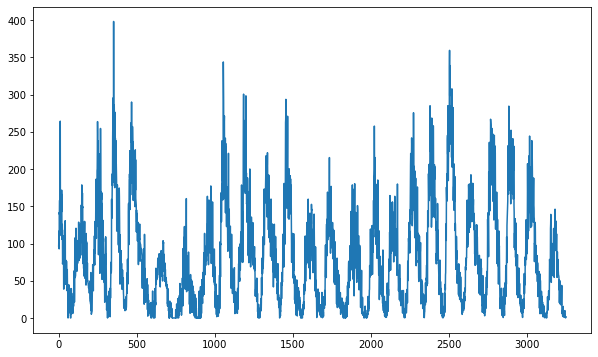

In [77]:
# Load TF/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Read the data
data=pandas.read_csv('Sunspots.csv',header=0)
dates = data['Date'].values
y = data['Monthly Mean Total Sunspot Number'].values
ndata=len(y)

# Plot the data
plt.plot(y)

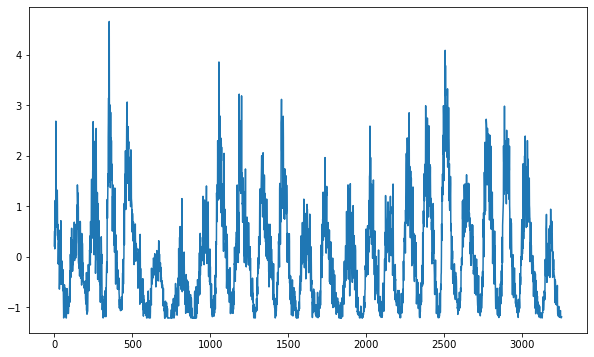

In [78]:
### Data preprocessing
# Standardize the data
mean_y = np.mean(y)
std_y = np.std(y)
y = (y-mean_y)/std_y
plt.plot(y)

In [65]:
### Training/test split

# We define a train/test split, here with 70 % training data
ntrain = int(ndata*0.7)
ntest = ndata-ntrain
print(f'Number of training/test data points: {ntrain}/{ntest}')

"""
 Sample indices for training data points, in total ntrain-1. We take -1 because
 we consider one-step-ahead prediction and the same data is used as both input
 and output. Hence, if we have in total ntrain data points in the training set,
 then only ntrain-1 can be used as inputs.
"""
ind_train = np.random.choice(ndata-1, size=ntrain-1, replace=False)
x_train = y[ind_train]  # Input is denoted by x
yt_train = y[ind_train+1] - x_train  # Output is denoted by yt, training outputs are the "increments" y[t+1]-y[t]

"""
 The test data consists of the non-training indices. Since we wish to predict the
 actual output y in the end, we use y[t+1] instead of the "increment" y[t+1]-y[t]
 as test target.
"""
ind_test = np.setdiff1d(np.arange(ndata-1), ind_train)  # Remaining indices are test data
x_test = y[ind_test]  # Test input
y_test = y[ind_test+1]  # Test target

# Reshape the data to fit the keras library
x_train = x_train.reshape((1,ntrain-1,1))
yt_train = yt_train.reshape((1,ntrain-1,1))
x_test = x_test.reshape((1,ntest,1))
y_test = y_test.reshape((1,ntest,1))


Number of training/test data points: 2276/976


In [66]:
### Set up a Simple RNN model
d = 10  # hidden state dimension

model=keras.Sequential([
    # Simple RNN layer with tanh activation
    layers.SimpleRNN(units = d, input_shape=(None,1), return_sequences=True, activation='tanh'),
    # A dense output layer with tanh activation
    layers.Dense(units = 1, activation='tanh')
])
    
# We store the initial weights in order to get an exact copy of the model when trying different training procedures    
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 10)          120       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(loss='mse', optimizer='rmsprop', metrics=['mse'])
# N.B. Here we use a small number of epochs for brevity, if you want to try the code.
# Having a too small number of epochs is _NOT_ one of the errors that you should find!
history = model.fit(x_train, yt_train,
                     epochs = 10, 
                     batch_size = 1,
                     verbose = 2,
                     validation_data = (x_test, y_test))

Train on 1 samples, validate on 1 samples
Epoch 1/10
1/1 - 1s - loss: 0.2856 - mse: 0.2856 - val_loss: 1.5655 - val_mse: 1.5655
Epoch 2/10
1/1 - 1s - loss: 0.2748 - mse: 0.2748 - val_loss: 1.5574 - val_mse: 1.5574
Epoch 3/10
1/1 - 1s - loss: 0.2675 - mse: 0.2675 - val_loss: 1.5501 - val_mse: 1.5501
Epoch 4/10
1/1 - 1s - loss: 0.2616 - mse: 0.2616 - val_loss: 1.5437 - val_mse: 1.5437
Epoch 5/10
1/1 - 1s - loss: 0.2566 - mse: 0.2566 - val_loss: 1.5378 - val_mse: 1.5378
Epoch 6/10
1/1 - 1s - loss: 0.2522 - mse: 0.2522 - val_loss: 1.5322 - val_mse: 1.5322
Epoch 7/10
1/1 - 1s - loss: 0.2483 - mse: 0.2483 - val_loss: 1.5268 - val_mse: 1.5268
Epoch 8/10
1/1 - 1s - loss: 0.2446 - mse: 0.2446 - val_loss: 1.5216 - val_mse: 1.5216
Epoch 9/10
1/1 - 1s - loss: 0.2412 - mse: 0.2412 - val_loss: 1.5165 - val_mse: 1.5165
Epoch 10/10
1/1 - 1s - loss: 0.2380 - mse: 0.2380 - val_loss: 1.5113 - val_mse: 1.5113


0.17691744818327565

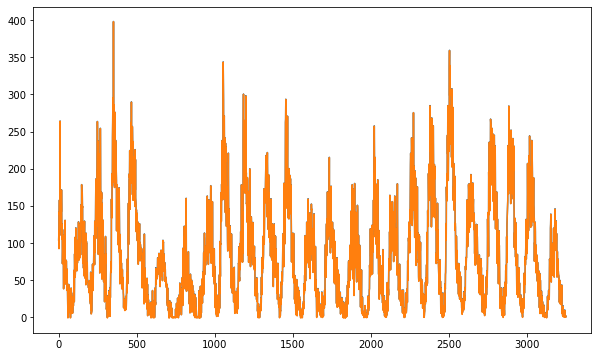

In [68]:
### Predict on all data using the final model.

# Rescale data with the MAX_VAL that we previously used for normalization,
# to get predictions in the correct interval
y = y*std_y + mean_y

# Since the model predicts the "increment", we add y[t+1] to the prediction
y_pred = model.predict(y[:-1].reshape(1, ndata-1, 1)).flatten() + y[1:]

### Plot the results
plt.plot(y[1:])
plt.plot(y_pred)

### Compute mean squared error
np.mean((y[1:] - y_pred)**2)

**Solution:**

List of errors:

1.  
2.  
3.  
4.  
5.  

**Solution:**

List of errors:

1.  The training/test split is done randomly (uniform sampling) which is a bad idea for time series data due to the temporal dependencies! We should have made the split deterministically, using the first 70 % of the data for training, and the last 30 % for testing.
2.  The training and test outputs should be defined in the same way. Hence, if the model is trained on predicting increments, then is should also be validated on predicting increments.
3.  The RNN output layer has a tanh nonlinearity, which means that the prediction will always be in the interval [-1,1]. However, the actual training data targets are outside of this interval. When working with real valued/numerical data we should not have a "squashing" nonlinearity such as tanh on the output layer. Simply removing this (`activation='linear'` fixes the issue)
4.  The "re-standardization", `y = y*std_y + mean_y`, should not be done _before_ feeding the data to the model to compute predictions, since the model is trained on standardized data.
5.  The most important error: we are cheating when computing the predictions by adding $y_t$ to the prediction $\hat y_{t|t-1}$. That is, we are effectively using $y_t$ to predict $y_t$, which is the reason for why is _seems_ to work well despite all the errors. We should instead add $y_{t-1}$ to the prediction.